![](../figs/se_03.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/solutions/SE03_SL_Training_neural_networks.ipynb)

## Workshop Overview
***
In this workshop, we explore autoencoders for unsupervised anomaly detection using real-world medical data. You'll learn how to build neural networks that learn to compress and reconstruct data, then use reconstruction error to identify abnormal patterns in heart sounds.

**Prerequisites**: Neural network basics (SE02), PyTorch fundamentals (SE01)

**Learning Objectives**:
- Understand the PyTorch training workflow from data to deployment
- Build and train autoencoders for dimensionality reduction
- Apply autoencoders for anomaly detection in medical audio
- Learn data preprocessing techniques for audio signals
- Implement proper train/validation/test splits
- Monitor and prevent overfitting using validation curves

**Clinical Context**: Early detection of cardiovascular and pulmonary diseases through heart and lung sound analysis can significantly improve patient outcomes. This workshop demonstrates how deep learning can assist in identifying abnormal patterns that may indicate underlying health conditions.

In [95]:
from pathlib import Path
import sys

# Setup paths for helper utilities
helper_utils = Path(Path.cwd().parent)
if str(helper_utils) not in sys.path:
    sys.path.append(str(helper_utils))

# Core libraries
import os
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Audio processing
import librosa
import librosa.display
import IPython.display as ipd

# Utilities
import utils
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize exercise checker and quiz manager
checker = utils.core.ExerciseChecker("SE03")
quizzer = utils.core.QuizManager("SE03")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="30"/> 1. The PyTorch Workflow
***

Most deep learning projects follow a systematic workflow. Whether you're building image classifiers, time series predictors, or anomaly detectors, the fundamental steps remain consistent. Understanding this workflow helps you structure your projects effectively.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs/pytorch_workflow.png" alt="PyTorch WorkFlow" align="center" style="width: 80%; height: auto; margin: 0 auto;">
</figure>

## The Complete Workflow

| Step | Description | Key Considerations |
|------|------------|-------------------|
| 📊 **Obtain Data** | Collect and explore your dataset | Data quality, source reliability, licensing |
| 🔧 **Prepare Data** | Convert to PyTorch-compatible format | Tensors, data types, shapes |
| 🧹 **Preprocess Data** | Clean, normalize, and split data | Train/val/test splits, normalization strategy |
| ⚡ **Activation Function** | Choose non-linearity for neurons | ReLU for hidden layers, task-specific for output |
| 🏗️ **Model Architecture** | Define network structure | Layer types, sizes, depth |
| 🎯 **Choose Optimizer** | Select parameter update algorithm | Adam, SGD, learning rate |
| 📉 **Choose Loss Function** | Define what to minimize | MSE for regression, CE for classification |
| 🔄 **Create Training Loop** | Implement forward/backward passes | Gradient computation, parameter updates |
| 🏋️ **Fit Model** | Train on data | Epochs, batch size, early stopping |
| 📈 **Evaluate Model** | Test performance | Validation metrics, generalization |
| ⚙️ **Improve Model** | Fine-tune and optimize | Hyperparameter tuning, regularization |
| 💾 **Save/Deploy Model** | Productionize your solution | Model serialization, deployment strategy |

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Remember**: This workflow is iterative. You'll often cycle back to earlier steps as you refine your model.

## Step 1: Obtain Data
***

### The Heart and Lung Sounds Dataset (HLS-CMDS)

In this workshop, we'll use the [Heart and Lung Sounds - Clinical Manikin Digital Stethoscope (HLS-CMDS) dataset](https://github.com/Torabiy/HLS-CMDS). This dataset contains 535 recordings of heart and lung sounds captured using a digital stethoscope from a clinical manikin, simulating real physiological conditions.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Dataset Overview**:
> - **Total Recordings**: 535 audio files (.wav format)
> - **Recording Types**: 50 heart sounds, 50 lung sounds, 145 mixed sounds (+ 145 source heart + 145 source lung)
> - **Auscultation Locations**: 12 chest landmarks
> - **Sample Rate**: Varies by recording
> - **Duration**: Typically 5-10 seconds per recording

### Sound Categories

The dataset includes both **normal** and **abnormal** cardiopulmonary sounds:

| Category | Sound Types | Clinical Significance |
|----------|-------------|----------------------|
| **Normal Heart** | Regular cardiac rhythm | Healthy baseline |
| **Heart Abnormalities** | Murmurs (early/mid/late systolic, diastolic), Third/Fourth heart sounds, Atrial fibrillation, Tachycardia, AV block | Potential valve disease, arrhythmias, heart failure |
| **Normal Lung** | Clear breath sounds | Healthy baseline |
| **Lung Abnormalities** | Wheezing, Crackles (fine/coarse), Rhonchi, Pleural rub | Asthma, pneumonia, bronchitis, pleural inflammation |

### Why Autoencoders for Anomaly Detection?

Traditional supervised learning requires labeled examples of every abnormality type. However:

1. **Normal data is abundant** - healthy recordings are easy to collect
2. **Abnormalities are rare** - pathological sounds are less common
3. **Unknown patterns exist** - new or rare conditions may not be in training data

**Autoencoders solve this** by learning to reconstruct *normal* sounds. When presented with abnormal sounds, they produce higher reconstruction errors, flagging them as anomalies.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Key Insight**: We'll train our autoencoder ONLY on normal heart sounds (filtering the Mix dataset), then use reconstruction error as an anomaly score. This is critical for anomaly detection - the model must learn what "normal" looks like, not abnormal patterns.

In [96]:
# Download and setup the HLS-CMDS dataset
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('HLS-CMDS',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=True)

print(f"✅ Dataset downloaded to: {dataset_path}")

Downloading:
Heart and Lung Sounds Dataset: 535 audio recordings of normal and abnormal cardiopulmonary sounds from clinical manikin for AI-based disease detection
> Authors: Yasaman Torabi, Shahram Shirani, James P. Reilly
> Year: 2025
> Website: https://archive.ics.uci.edu/dataset/1202/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope



Extracting hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope.zip: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope.zip
Found nested archive: HLS-CMDS.zip


Extracting HLS-CMDS.zip: 100%|██████████| 9/9 [00:00<00:00, 134.00it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/HLS-CMDS.zip
Found nested archive: HS.zip


Extracting HS.zip: 100%|██████████| 106/106 [00:00<00:00, 2488.43it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/HS.zip
Found nested archive: LS.zip


Extracting LS.zip: 100%|██████████| 106/106 [00:00<00:00, 1783.58it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/LS.zip
Found nested archive: Mix.zip


Extracting Mix.zip: 100%|██████████| 873/873 [00:00<00:00, 2057.38it/s]


Removed compressed file: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/Mix.zip
✅ Dataset downloaded to: /Users/hai/Documents/Github/uom_fse_dl_workshop/solutions/datasets/hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope


In [125]:
# List the contents of the dataset
print("📂 Dataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(str(dataset_path), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    
    # Show CSV files and a few WAV files
    csv_files = [f for f in files if f.endswith('.csv')]
    wav_files = [f for f in files if f.endswith('.wav') or f.endswith('.WAV')]
    
    for file in csv_files:
        print(f'{subindent}{file}')
    
    if wav_files:
        for file in wav_files[:3]:
            print(f'{subindent}{file}')
        if len(wav_files) > 3:
            print(f'{subindent}... and {len(wav_files) - 3} more WAV files')
    
    if level > 1:  # Limit depth
        break

📂 Dataset structure:
hls-cmds:+heart+and+lung+sounds+dataset+recorded+from+a+clinical+manikin+using+digital+stethoscope/
  HS.csv
  Mix.csv
  LS.csv
  Mix/
    L0014.wav
    L0028.wav
    M0005.wav
    ... and 432 more WAV files
  __MACOSX/
    ._LS.csv
    ._HS.csv
    ._Mix.csv
  HS/
    M_ESM_RUSB.wav
    F_LDM_LUSB.wav
    F_ESM_LUSB.wav
    ... and 47 more WAV files
  LS/
    F_W_RUA.wav
    F_CC_LUA.wav
    M_PR_RMA.wav
    ... and 47 more WAV files


In [98]:
print("=" * 70)
print("LOADING METADATA AND AUDIO FILES")
print("=" * 70)
# Load metadata CSV files
heart_metadata_path = dataset_path / 'HS.csv'
mix_metadata_path = dataset_path / 'Mix.csv'

# Get paths to audio folders
heart_sounds_folder = dataset_path / 'HS'
mix_sounds_folder = dataset_path / 'Mix'

# Load Mix metadata (contains 145 heart, 145 lung, 145 mixed sounds)
if mix_metadata_path.exists():
    mix_metadata = pd.read_csv(mix_metadata_path)
    print(f"\nMix dataset loaded:")
    print(f"   Total recordings: {len(mix_metadata)}")
    print(f"   Columns: {list(mix_metadata.columns)}")
else:
    print("\n⚠️ Warning: Mix.csv not found!")

# Load HS metadata for testing
if heart_metadata_path.exists():
    heart_metadata = pd.read_csv(heart_metadata_path)
    print(f"\n Heart sounds (HS) dataset loaded:")
    print(f"   Total recordings: {len(heart_metadata)}")
    print(f" Columns: {list(heart_metadata.columns)}")
else:
    print("\n⚠️ Warning: HS.csv not found!")

LOADING METADATA AND AUDIO FILES

Mix dataset loaded:
   Total recordings: 145
   Columns: ['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location', 'Heart Sound ID', 'Lung Sound ID', 'Mixed Sound ID']

 Heart sounds (HS) dataset loaded:
   Total recordings: 50
 Columns: ['Gender', 'Heart Sound Type', 'Location', 'Heart Sound ID']


In [99]:
heart_metadata.head()

,Gender,Heart Sound Type,Location,Heart Sound ID
0,F,Normal,RC,F_N_RC
1,F,Normal,LC,F_N_LC
2,M,Normal,RUSB,M_N_RUSB
3,F,Normal,LUSB,F_N_LUSB
4,F,Normal,LLSB,F_N_LLSB


In [100]:
mix_metadata.head()

,Gender,Heart Sound Type,Lung Sound Type,Location,Heart Sound ID,Lung Sound ID,Mixed Sound ID
0,F,Late Systolic Murmur,Rhonchi,LUSB,H0001,L0001,M0001
1,F,S3,Normal,RLA,H0002,L0002,M0002
2,M,Atrial Fibrillation,Normal,LMA,H0003,L0003,M0003
3,F,S3,Coarse Crackles,Apex,H0004,L0004,M0004
4,M,AV Block,Fine Crackles,RUSB,H0005,L0005,M0005


### Initial Data Exploration

Before diving into model building, it's essential to explore the dataset. This helps us understand the data distribution, identify any issues, and plan our preprocessing steps.

In [159]:
# Display a random heart sound recording and its mel spectrogram
random_id = random.choice(heart_metadata['Heart Sound ID'])
print(f"Randomly selected Heart Sound ID: {random_id}")
random_audio_path = heart_sounds_folder / (random_id + ".wav")

display(ipd.Audio(str(random_audio_path), autoplay=True))

y, sr = librosa.load(random_audio_path, sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Create subplots with plotly for interactive visualization
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(f'{random_id} - Waveform'.upper(), f'{random_id} - Mel Spectrogram'.upper()),
    column_widths=[0.5, 0.75]
)

# Waveform
time_axis = np.linspace(0, len(y) / sr, len(y))
fig.add_trace(
    go.Scatter(
        x=time_axis,
        y=y,
        mode='lines',
        line=dict(color='steelblue', width=1),
        name='Waveform'
    ),
    row=1, col=1
)

# Mel Spectrogram
fig.add_trace(
    go.Heatmap(
        z=S_dB,
        x=librosa.frames_to_time(np.arange(S_dB.shape[1]), sr=sr),
        y=librosa.mel_frequencies(n_mels=S_dB.shape[0]),
        colorbar=dict(title='dB', x=1.15),
        name='Mel Spectrogram'
    ),
    row=1, col=2
)

# Update layout
fig.update_xaxes(title_text='Time (s)'.upper(), row=1, col=1)
fig.update_yaxes(title_text='Amplitude'.upper(), row=1, col=1)
fig.update_xaxes(title_text='Time (s)'.upper(), row=1, col=2)
fig.update_yaxes(title_text='Frequency (Hz)'.upper(), type='log', row=1, col=2)

fig.update_layout(
    height=400,
    showlegend=False
)

fig.show()

Randomly selected Heart Sound ID: F_MSM_LLSB


In [158]:
# Create interactive bar chart with overlapping bars
mix_counts = mix_metadata['Heart Sound Type'].value_counts()
heart_counts = heart_metadata['Heart Sound Type'].value_counts()

# Get all unique heart sound types from both datasets
all_types = sorted(set(mix_counts.index).union(set(heart_counts.index)))

# Create aligned data for both datasets
mix_values = [mix_counts.get(t, 0) for t in all_types]
heart_values = [heart_counts.get(t, 0) for t in all_types]

fig = go.Figure()

# Mix dataset (more transparent, behind)
fig.add_trace(
    go.Bar(
        x=all_types, 
        y=mix_values, 
        name="Mix Dataset",
        marker_color='steelblue',
        opacity=0.6
    )
)

# HS dataset (less transparent, in front)
fig.add_trace(
    go.Bar(
        x=all_types, 
        y=heart_values, 
        name="HS Dataset",
        marker_color='coral',
        opacity=0.8
    )
)

fig.update_layout(
    title="Heart Sound Distribution Comparison".upper(),
    xaxis_title="Heart Sound Type".upper(),
    yaxis_title="Count".upper(),
    barmode='overlay',  # Overlay bars instead of grouping
    height=500,
    xaxis={'tickangle': -45}
)

fig.show()

In [103]:
# Analyze recording lengths in Mix dataset (normal sounds only)
print("=" * 70)
print("ANALYZING RECORDING LENGTHS FOR DATA AUGMENTATION PLANNING...")
print("=" * 70)

normal_mix_files = mix_metadata[mix_metadata['Heart Sound Type'] == 'Normal']['Heart Sound ID'].tolist()

durations = []
sample_rates = []

for sound_id in normal_mix_files:
    sound_id = str(sound_id).strip()
    if sound_id == 'nan' or pd.isna(sound_id):
        continue
        
    file_path = mix_sounds_folder / (sound_id + '.wav')
    if file_path.exists():
        audio, sr = librosa.load(file_path, sr=None)
        duration = len(audio) / sr
        durations.append(duration)
        sample_rates.append(sr)

durations = np.array(durations)
print(f"Normal heart sound recordings from Mix dataset:")
print(f"   Number of recordings: {len(durations)}")
print(f"   Duration - Mean: {durations.mean():.2f}s, Std: {durations.std():.2f}s")
print(f"   Duration - Min: {durations.min():.2f}s, Max: {durations.max():.2f}s")
print(f"   Sample rates: {set(sample_rates)}")
print(f"\n💡 Strategy: Slice recordings into overlapping segments for augmentation")

ANALYZING RECORDING LENGTHS FOR DATA AUGMENTATION PLANNING...
Normal heart sound recordings from Mix dataset:
   Number of recordings: 13
   Duration - Mean: 15.00s, Std: 0.00s
   Duration - Min: 15.00s, Max: 15.00s
   Sample rates: {4000}

💡 Strategy: Slice recordings into overlapping segments for augmentation


### Data Augmentation for Small Datasets
***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Why Augmentation?**: With only 13 normal training samples, we risk overfitting. Data augmentation artificially increases the dataset size by creating variations of existing samples.

**Audio Segmentation Strategy**

Since heart sounds are cyclical, we can slice long recordings into shorter segments. Each segment captures multiple heartbeat cycles and can be treated as an independent sample.

| Augmentation Parameter | Value | Rationale |
|------------------------|-------|-----------|
| **Original Duration** | 15 seconds | All normal recordings are 15s |
| **Segment Duration** | 3 seconds | Captures 3 heartbeats at 60 BPM |
| **Overlap** | 1.5 seconds (50%) | Ensures no heartbeats are cut off |
| **Segments per Recording** | ~9 segments | With 50% overlap from 15s |

**Mathematical Formulation:**

For a recording of duration $T$ with segment length $L$ and overlap $O$:

$$N_{segments} = \lfloor \frac{T - L}{L - O} \rfloor + 1$$

For our case: $N_{segments} = \lfloor \frac{15 - 3}{3 - 1.5} \rfloor + 1 = 9$ segments

**Expected Augmentation Results:**
- Original: 13 samples
- After augmentation: 13 × 9 = **117 samples** 
- Increase: **9× more training data** 🚀

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Important**: Each segment still represents a "normal" heart sound pattern, maintaining label integrity.

In [160]:
# Data Augmentation Functions
def slice_audio_into_segments(audio, sr, segment_duration=3.0, overlap=0.5):
    """
    Slice an audio signal into overlapping segments
    
    Args:
        audio: Audio signal (numpy array)
        sr: Sample rate
        segment_duration: Duration of each segment in seconds
        overlap: Overlap fraction (0.0 to 1.0)
    
    Returns:
        List of audio segments
    """
    segment_samples = int(segment_duration * sr)
    hop_samples = int(segment_samples * (1 - overlap))
    
    segments = []
    start = 0
    
    while start + segment_samples <= len(audio):
        segment = audio[start:start + segment_samples]
        segments.append(segment)
        start += hop_samples
    
    return segments


### Why Not Use Raw Audio Directly?
***
Raw audio waveforms present significant challenges for machine learning:

| Challenge | Issue | Impact on ML |
|-----------|-------|--------------|
| **High Dimensionality** | 15s audio at 22kHz = 330,000 data points | Computationally expensive, slow training |
| **Temporal Redundancy** | Adjacent samples are highly correlated | Inefficient representation |
| **No Feature Emphasis** | All frequencies treated equally | Model can't distinguish important patterns |
| **Noise Sensitivity** | Background noise affects every sample | Poor generalization |

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **The Solution**: We need a compact, meaningful representation that captures the essential characteristics of sound while discarding irrelevant details.

### What Are MFCCs?

**Mel Frequency Cepstral Coefficients (MFCCs)** are a compact representation of audio that mimics how humans perceive sound. They capture the frequency content of audio in a way that emphasizes perceptually important information.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Key Insight**: The human ear doesn't perceive frequencies linearly - we're more sensitive to differences in lower frequencies. MFCCs account for this using the **mel scale**.

### The Mel Scale

The mel scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another:

$$m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)$$

Where:
- $m$ is the subjective pitch in mels
- $f$ is the actual frequency in Hz

| Frequency Range | Human Sensitivity | Mel Scale Behavior |
|-----------------|-------------------|-------------------|
| **Low (< 1000 Hz)** | High sensitivity to small changes | Finer resolution (more detail) |
| **High (> 4000 Hz)** | Lower sensitivity to changes | Coarser resolution (less detail) |

### MFCC Extraction Pipeline

The transformation from raw audio to MFCCs involves several steps:

```
Raw Audio → Short-Time Fourier Transform (STFT) → Mel Filterbank → Log Power → Discrete Cosine Transform (DCT) → MFCCs
```

**Step-by-Step Process:**

1. **STFT**: Convert time-domain signal to frequency-domain
   - Breaks audio into short overlapping windows
   - Computes frequency content of each window
   
2. **Mel Filterbank**: Apply mel-scaled filters
   - Groups frequencies according to human perception
   - More filters at low frequencies, fewer at high frequencies
   
3. **Log Power**: Take logarithm of filter outputs
   - Mimics human loudness perception (logarithmic)
   - Compresses dynamic range
   
4. **DCT**: Decorrelate the coefficients
   - Produces compact, independent features
   - First few coefficients capture most information

### Why MFCCs for Heart Sound Analysis?

MFCCs are particularly well-suited for distinguishing normal from abnormal heart sounds:

| Heart Sound Feature | How MFCCs Capture It | Diagnostic Value |
|---------------------|---------------------|------------------|
| **Murmur Frequency** | Specific frequency bands activated | Valve abnormalities |
| **Timing Patterns** | Temporal structure in coefficients | Rhythm irregularities |
| **Intensity Variations** | Log-scale energy representation | Intensity of abnormalities |
| **Harmonic Structure** | First few coefficients capture harmonics | Sound quality differences |

### MFCC Benefits for Our Task

| Benefit | Description | Impact on Our Model |
|---------|-------------|---------------------|
| **Dimensionality Reduction** | 330,000 samples → ~1,690 features (13 coefficients × 130 time frames) | 195× reduction, faster training |
| **Perceptual Relevance** | Emphasizes diagnostically important frequencies | Better anomaly detection |
| **Noise Robustness** | Filters out high-frequency noise | More reliable features |
| **Standard Practice** | Widely used in audio ML | Proven effectiveness, reproducibility |
| **Fixed-Length Output** | Same feature dimensions regardless of audio length | Easy to batch and process |

### Our MFCC Configuration

For this workshop, we extract:

```python
n_mfcc = 13          # Number of MFCC coefficients
max_len = 130        # Maximum time frames (padded/truncated)
feature_dim = 1690   # Final feature vector size (13 × 130)
```

**Why 13 coefficients?**
- Captures essential frequency information
- Standard in speech/audio processing
- Balances information vs. computational cost
- Higher coefficients capture less perceptually relevant detail

**Why 130 time frames?**
- Accommodates 3-second segments at typical frame rates
- Allows padding/truncation for consistency
- Fixed-length input required for neural networks

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Important**: MFCCs are the standard feature representation for audio classification tasks. By using them, we're focusing the autoencoder on learning meaningful acoustic patterns rather than irrelevant temporal details.

In [161]:
def extract_mfcc_from_audio(audio, sr, n_mfcc=13, max_len=130):
    """
    Extract MFCC features from an audio signal (not file)
    
    Args:
        audio: Audio signal (numpy array)
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients to extract
        max_len: Maximum length to pad/truncate the features
    
    Returns:
        Flattened MFCC feature vector
    """
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Pad or truncate to fixed length
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    
    # Flatten to 1D vector
    return mfccs.flatten()

In [162]:
def load_audio_features(file_names, 
                       sounds_folder, 
                       augment=False,
                       segment_duration=3.0,
                       overlap=0.5,
                       metadata=None, 
                       metadata_label_col=None, 
                       desc="Processing sounds"):
    """
    Load audio files, optionally apply segmentation augmentation, and extract MFCC features
    
    Args:
        file_names: List of sound IDs (file names without or with extension)
        sounds_folder: Path to the folder containing audio files
        augment: Whether to apply segmentation augmentation (default: False)
        segment_duration: Duration of each segment in seconds (for augmentation)
        overlap: Overlap fraction for segments (for augmentation)
        metadata: Optional DataFrame with metadata for extracting labels
        metadata_label_col: Column name in metadata for labels (e.g., 'Heart Sound Type')
        desc: Description for progress bar
    
    Returns:
        features_array: NumPy array of extracted features (shape: [n_samples, n_features])
        sound_ids: List of sound IDs corresponding to each sample
        labels: List of labels (if metadata provided, otherwise None)
        augmentation_info: Dictionary with augmentation statistics
    """
    features_list = []
    sound_ids_list = []
    labels_list = [] if metadata is not None and metadata_label_col is not None else None
    
    total_segments = 0
    original_count = 0
    
    for sound_id in tqdm(file_names, desc=desc):
        # Ensure sound_id is a string and clean it
        sound_id = str(sound_id).strip()
        if sound_id == 'nan' or pd.isna(sound_id):
            continue
        
        # Try to find the file with different extensions
        file_path = sounds_folder / (sound_id + '.wav') if not sound_id.endswith('.wav') else sounds_folder / sound_id
        
        # Try alternate extension if not found
        if not file_path.exists():
            file_path = sounds_folder / sound_id.replace('.wav', '.WAV')
        
        if file_path.exists():
            try:
                # Load audio
                audio, sr = librosa.load(file_path, sr=None)
                original_count += 1
                
                if augment:
                    # Slice into segments
                    segments = slice_audio_into_segments(audio, sr, segment_duration, overlap)
                    
                    # Extract features from each segment
                    for i, segment in enumerate(segments):
                        features = extract_mfcc_from_audio(segment, sr)
                        features_list.append(features)
                        sound_ids_list.append(f"{sound_id}_seg{i}")
                        
                        # Extract label from metadata if provided
                        if labels_list is not None:
                            label = metadata[metadata['Heart Sound ID'] == sound_id][metadata_label_col].values[0]
                            labels_list.append(label)
                        
                        total_segments += 1
                else:
                    # No augmentation - extract features from full audio
                    features = extract_mfcc_from_audio(audio, sr)
                    features_list.append(features)
                    sound_ids_list.append(sound_id)
                    
                    # Extract label from metadata if provided
                    if labels_list is not None:
                        label = metadata[metadata['Heart Sound ID'] == sound_id][metadata_label_col].values[0]
                        labels_list.append(label)
                    
                    total_segments += 1
                    
            except Exception as e:
                print(f"Error processing {sound_id}: {e}")
    
    features_array = np.array(features_list)
    
    augmentation_info = {
        'original_files': original_count,
        'total_samples': total_segments,
        'augmentation_factor': total_segments / original_count if original_count > 0 else 1
    }
    
    return features_array, sound_ids_list, labels_list, augmentation_info


print("✅ Data augmentation functions defined!")
print("   Use augment=True for training data (creates 3s segments)")
print("   Use augment=False for full-length recordings")

✅ Data augmentation functions defined!
   Use augment=True for training data (creates 3s segments)
   Use augment=False for full-length recordings


### Augmentation Strategy Summary

**Problem:** Only 13 normal training samples → High risk of overfitting

**Solution:** Audio segmentation with overlapping windows

| Parameter | Value | Justification |
|-----------|-------|---------------|
| **Original Duration** | 15 seconds | All recordings same length |
| **Segment Duration** | 3 seconds | Captures ~3 heartbeats at 60 BPM |
| **Overlap** | 50% (1.5s) | Prevents cutting heartbeats, increases diversity |
| **Result** | 9 segments per recording | Mathematics: $\lfloor\frac{15-3}{3-1.5}\rfloor + 1 = 9$ |

**Impact:**
- ✅ **Before augmentation:** 13 samples
- 🚀 **After augmentation:** 117 samples (9× increase)
- 📊 **Training set:** 93 samples (instead of 10)
- 📋 **Validation set:** 24 samples (instead of 3)
- 🎯 **Test set:** 50 samples (unchanged - full recordings)

**Key Principles:**
1. ✅ Only augment training/validation data
2. ✅ Test data uses full recordings for realistic evaluation  
3. ✅ Each segment maintains "normal" label integrity
4. ✅ Overlapping segments increase pattern diversity

## Step 2 and 3: Prepare and Preprocess Data
***

Let's implement the data preparation and preprocessing steps. This includes loading the audio files, extracting MFCC features, and creating PyTorch datasets and dataloaders for training our autoencoder. 

First, we are going to start by creating the augmented dataset by slicing the original audio recordings into overlapping segments.

In [116]:
# Load features from Mix heart sounds (for training)
# CRITICAL: Filter for ONLY normal heart sounds + Apply augmentation
print("\n" + "=" * 70)
print("TRAINING DATA PREPARATION WITH AUGMENTATION")
print("=" * 70)

# Filter Mix metadata for normal heart sounds only
normal_mix_mask = mix_metadata['Heart Sound Type'] == 'Normal'
abnormal_mix_mask = ~normal_mix_mask

# Extract only normal heart sound IDs for training
mix_normal_heart_files = mix_metadata[normal_mix_mask]['Heart Sound ID'].tolist()

# Load with augmentation
train_features, train_sound_ids, _, aug_info = load_audio_features(
    file_names=mix_normal_heart_files,
    sounds_folder=mix_sounds_folder,
    augment=True,
    segment_duration=3.0,
    overlap=0.5,
    desc="Processing Normal Mix heart sounds"
)

print(f"   Original recordings: {aug_info['original_files']}")
print(f"   Total training samples after augmentation: {aug_info['total_samples']}")
print(f"   Augmentation factor: {aug_info['augmentation_factor']:.1f}x")
print(f"   Feature shape per sample: {train_features.shape}")


TRAINING DATA PREPARATION WITH AUGMENTATION


Processing Normal Mix heart sounds: 100%|██████████| 13/13 [00:00<00:00, 32.08it/s]

   Original recordings: 13
   Total training samples after augmentation: 117
   Augmentation factor: 9.0x
   Feature shape per sample: (117, 1690)


In [120]:
# Load HS dataset for testing with same 3s segmentation as training data
# CRITICAL: Use 3s segments for consistency with training data
print("\n" + "=" * 70)
print("TEST DATA PREPARATION (With 3s Segmentation)")
print("=" * 70)

normal_mask = heart_metadata['Heart Sound Type'] == 'Normal'
abnormal_mask = ~normal_mask

normal_test_files = heart_metadata[normal_mask]['Heart Sound ID'].tolist()
abnormal_test_files = heart_metadata[abnormal_mask]['Heart Sound ID'].tolist()

# Load normal test sounds WITH 3s segmentation (same as training)
normal_test_features, _, _, normal_aug_info = load_audio_features(
    file_names=normal_test_files,
    sounds_folder=heart_sounds_folder,
    augment=True,  # Use same segmentation as training
    segment_duration=3.0,
    overlap=0.5,
    desc="Processing normal HS sounds (3s segments)"
)
print(f"✅ Loaded {len(normal_test_features)} normal 3s segments from {len(normal_test_files)} recordings\n")

# Load abnormal test sounds WITH 3s segmentation
abnormal_test_features, _, abnormal_test_labels, abnormal_aug_info = load_audio_features(
    file_names=abnormal_test_files,
    sounds_folder=heart_sounds_folder,
    augment=True,  # Use same segmentation as training
    segment_duration=3.0,
    overlap=0.5,
    metadata=heart_metadata,
    metadata_label_col='Heart Sound Type',
    desc="Processing abnormal HS sounds (3s segments)"
)
print(f"✅ Loaded {len(abnormal_test_features)} abnormal 3s segments from {len(abnormal_test_files)} recordings")

# Display abnormal sound types
if abnormal_test_labels:
    print(f"\nAbnormal sound types in test set:")
    for sound_type in sorted(set(abnormal_test_labels)):
        count = abnormal_test_labels.count(sound_type)
        print(f"   {sound_type}: {count} segments")


TEST DATA PREPARATION (With 3s Segmentation)


Processing normal HS sounds (3s segments): 100%|██████████| 9/9 [00:00<00:00, 71.67it/s]


✅ Loaded 81 normal 3s segments from 9 recordings



Processing abnormal HS sounds (3s segments): 100%|██████████| 41/41 [00:00<00:00, 67.31it/s]


✅ Loaded 369 abnormal 3s segments from 41 recordings

Abnormal sound types in test set:
   AV Block: 27 segments
   Atrial Fibrillation: 36 segments
   Early Systolic Murmur: 54 segments
   Late Diastolic Murmur: 54 segments
   Late Systolic Murmur: 45 segments
   Mid Systolic Murmur: 63 segments
   S3: 45 segments
   S4: 18 segments
   Tachycardia: 27 segments


### Training, Validation, and Test Sets
***

Just as in supervised learning, we need to split our data into separate sets. For autoencoders:

| Dataset | Purpose | Typical Split | Usage | Content for Our Task |
|---------|---------|---------------|--------|----------------------|
| **Training Set** | Learn to reconstruct normal patterns | 60-70% | Every training iteration | Primarily normal heart sounds |
| **Validation Set** | Monitor reconstruction quality during training | 15-20% | During model development | Mix of normal and some abnormal sounds |
| **Test Set** | Final evaluation of anomaly detection | 15-20% | Once, after training | Balanced mix of normal and abnormal sounds |

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Key Difference**: Unlike supervised learning, our training set contains mostly normal examples. The model learns what "normal" looks like, and anomalies naturally produce higher reconstruction errors.

In [122]:
# Split data into train/validation/test sets with consistent 3s segmentation
print("\n" + "=" * 70)
print("SPLITTING DATA INTO TRAIN/VAL/TEST")
print("=" * 70)

# Split Mix heart sounds (normal only) into training and validation (80/20)
X_train, X_val = train_test_split(
    train_features, test_size=0.2, random_state=42
)

# Create labels for training/validation (all normal from Mix)
y_train = np.zeros(len(X_train))
y_val = np.zeros(len(X_val))

# Test set from HS dataset (normal + abnormal)
X_test = np.vstack([normal_test_features, abnormal_test_features])
y_test = np.concatenate([
    np.zeros(len(normal_test_features)),
    np.ones(len(abnormal_test_features))
])

print(f"\nTRAINING SET (Mix - NORMAL only):")
print(f"   Samples: {X_train.shape[0]} (3s segments)")
print(f"   Source: {aug_info['original_files']} recordings × {aug_info['augmentation_factor']:.1f} augmentation")
print(f"   Normal: {X_train.shape[0]} (100%)")

print(f"\nVALIDATION SET (Mix - NORMAL only):")
print(f"   Samples: {X_val.shape[0]} (3s segments)")
print(f"   Normal: {X_val.shape[0]} (100%)")

print(f"\nTEST SET (HS - Independent dataset):")
print(f"   Samples: {X_test.shape[0]} (3s segments)")
print(f"   Normal: {(y_test==0).sum()} segments from {len(normal_test_files)} recordings ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"   Abnormal: {(y_test==1).sum()} segments from {len(abnormal_test_files)} recordings ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

print(f"\n✅ All datasets use consistent 3s segmentation!")
print(f"   Feature dimensions: {X_train.shape[1]}")
print(f"   Augmentation increased training data {aug_info['augmentation_factor']:.1f}x")


SPLITTING DATA INTO TRAIN/VAL/TEST

TRAINING SET (Mix - NORMAL only):
   Samples: 93 (3s segments)
   Source: 13 recordings × 9.0 augmentation
   Normal: 93 (100%)

VALIDATION SET (Mix - NORMAL only):
   Samples: 24 (3s segments)
   Normal: 24 (100%)

TEST SET (HS - Independent dataset):
   Samples: 450 (3s segments)
   Normal: 81 segments from 9 recordings (18.0%)
   Abnormal: 369 segments from 41 recordings (82.0%)

✅ All datasets use consistent 3s segmentation!
   Feature dimensions: 1690
   Augmentation increased training data 9.0x


### Normalization
***

Normalization is crucial for neural network training. We'll use **Standard Scaling** (Z-score normalization) for our MFCC features:

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ is the normalized value  
- $x$ is the original value
- $\mu$ is the mean computed from training data
- $\sigma$ is the standard deviation computed from training data

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Critical**: Always fit the scaler on training data only, then apply to validation and test sets. This prevents data leakage!

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 1**: Standard Scaling with scikit-learn

```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on training data only
scaler.fit(X_train)

# Transform all datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Inverse transform to get original values
X_train_original = scaler.inverse_transform(X_train_scaled)
```

In [163]:
# Exercise 1: Data Normalization and Tensor Conversion 🎯

# In this exercise, you will:
# 1. Normalize the audio features using StandardScaler
# 2. Convert numpy arrays to PyTorch tensors
# 3. Verify the normalization worked correctly

# Create a StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on training data
scaler.fit(X_train)

# Transform all datasets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [164]:
# Verify normalization
print("Normalization check:")
print(f"   Training data - Mean: {X_train_tensor.mean().item():.6f}, Std: {X_train_tensor.std().item():.4f}")
print(f"   Validation data - Mean: {X_val_tensor.mean().item():.6f}, Std: {X_val_tensor.std().item():.4f}")
print(f"   Test data - Mean: {X_test_tensor.mean().item():.6f}, Std: {X_test_tensor.std().item():.4f}")

print(f"\nData shapes:")
print(f"   Train: {X_train_tensor.shape}")
print(f"   Validation: {X_val_tensor.shape}")
print(f"   Test: {X_test_tensor.shape}")

Normalization check:
   Training data - Mean: -0.000000, Std: 0.4297
   Validation data - Mean: -0.000821, Std: 0.4287
   Test data - Mean: -0.041916, Std: 0.5778

Data shapes:
   Train: torch.Size([93, 1690])
   Validation: torch.Size([24, 1690])
   Test: torch.Size([450, 1690])


## Step 4: Activation Function
***
The next step is to choose an activation function for the model. The activation function introduces non-linearity to the model, allowing it to learn complex relationships in the data. The following table lists some common activation functions used in neural networks, along with their characteristics and best use cases:

| Function | Formula | Range | PyTorch Implementation | Best Used For |
|----------|---------|-------|-------------------|---------------|
| ReLU | $f(x) = \max(0, x)$ | $[0, \infty)$ | `torch.nn.ReLU()` | Hidden layers in most networks |
| Sigmoid | $f(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | `torch.nn.Sigmoid()` | Binary classification, gates in LSTMs |
| Tanh | $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | `torch.nn.Tanh()` | Hidden layers when output normalization is needed |
| Leaky ReLU | $f(x) = \max(\alpha x, x)$ | $(-\infty, \infty)$ | `torch.nn.LeakyReLU(negative_slope=0.01)` | Preventing "dead neurons" problem |
| Softmax | $f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$ | $(0, 1)$ | `torch.nn.Softmax(dim=1)` | Multi-class classification output layer |

The choice of activation function depends on the specific problem and the architecture of the neural network. 

> <img src="../figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - ReLU is the most commonly used activation function in hidden layers of deep networks due to its simplicity and effectiveness.
> - The activation function for the output layer depends on the type of problem being solved (e.g., regression, binary classification, multi-class classification).
***
> <img src="../figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> **Common Mistakes to Avoid**: 
> - Mixing activation functions in the same layer (e.g., using ReLU and sigmoid together) can lead to unexpected behavior.
> - Using activation functions that saturate (like sigmoid) in hidden layers can lead to vanishing gradients, making training difficult.
> - Forgetting to apply the activation function to the output layer can lead to incorrect predictions (e.g., not using softmax for multi-class classification).
> - Not considering the range of the output when choosing the activation function (e.g., using sigmoid for regression tasks).


## Step 5: Model Architecture - Introducing Autoencoders
***

### What is an Autoencoder?

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: An **autoencoder** is a neural network trained to reconstruct its input. It learns to compress data into a lower-dimensional representation (encoding) and then reconstruct it back (decoding).

### Architecture Components

An autoencoder consists of two main parts:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs/autoencoder.png" alt="Autoencoder Architecture" align="center" style="width: 60%; height: auto; margin: 0 auto;" onerror="this.style.display='none'">
</figure>

| Component | Description | Mathematical Representation |
|-----------|-------------|----------------------------|
| **Encoder** | Compresses input to lower dimensions | $\mathbf{z} = f_{enc}(\mathbf{x})$ |
| **Latent Space** | Compressed representation (bottleneck) | $\mathbf{z} \in \mathbb{R}^d$ where $d << n$ |
| **Decoder** | Reconstructs input from latent space | $\mathbf{\hat{x}} = f_{dec}(\mathbf{z})$ |

### Why Autoencoders for Anomaly Detection?

The key insight: **If trained only on normal data, the autoencoder learns to reconstruct normal patterns well but struggles with abnormal patterns.**

| Scenario | Reconstruction Error | Interpretation |
|----------|---------------------|----------------|
| Normal heart sound | Low (≈ 0) | Model has seen similar patterns |
| Abnormal heart sound | High (>> 0) | Model hasn't learned this pattern |

### Mathematical Formulation

For input $\mathbf{x} \in \mathbb{R}^n$:

**Encoding:**
$$\mathbf{z} = \sigma(\mathbf{W}_{enc}\mathbf{x} + \mathbf{b}_{enc})$$

**Decoding:**
$$\mathbf{\hat{x}} = \sigma(\mathbf{W}_{dec}\mathbf{z} + \mathbf{b}_{dec})$$

**Reconstruction Error:**
$$\mathcal{L} = ||\mathbf{x} - \mathbf{\hat{x}}||^2 = \sum_{i=1}^{n}(x_i - \hat{x}_i)^2$$

### Network Design Considerations

| Layer Type | Encoder | Decoder | Activation |
|------------|---------|---------|------------|
| **Input Layer** | Feature dimension (e.g., 1690) | Latent dimension (e.g., 32) | - |
| **Hidden Layer 1** | 512 neurons | 128 neurons | ReLU |
| **Hidden Layer 2** | 128 neurons | 512 neurons | ReLU |
| **Output Layer** | 32 neurons (latent) | Original dimension | Linear/Sigmoid |

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Symmetric Architecture**: Decoders typically mirror encoders. If encoder is [1690 → 512 → 128 → 32], decoder is [32 → 128 → 512 → 1690].

### Latent Space Dimensionality

The bottleneck dimension determines compression strength:

- **Too large** (e.g., 512): Model may memorize noise, poor anomaly detection
- **Too small** (e.g., 8): Loses important information, poor reconstruction  
- **Sweet spot** (e.g., 32-64): Captures essential patterns, discards noise


### Initialising Weights and Biases
***

In the previous session we looked at the concept of weights and biases. With our Perceptron we initialised the weights and biases to random values. In PyTorch, we can use different methods to initialise the weights and biases of a neural network.

The importance of initialising weights and biases lies in the fact that they can significantly affect the convergence speed and performance of the neural network. Proper initialisation can help prevent issues such as vanishing or exploding gradients, which can hinder the training process.

| Initialisation Method | Formula | PyTorch Code | Description |
|-----------------------|----------|--------------|-------------|
| Xavier/Glorot Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}})$ | `torch.nn.init.xavier_uniform_(tensor)` | Suitable for sigmoid and tanh activations. |
| He Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Kaiming Normal Initialisation | $W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ | `torch.nn.init.kaiming_normal_(tensor)` | Suitable for ReLU activations. |
| Kaiming Uniform Initialisation | $W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Zero Initialisation | $W = 0$ | `torch.nn.init.zeros_(tensor)` | All weights are set to zero. Not recommended. |
| Random Initialisation | $W \sim \mathcal{U}(-1, 1)$ | `torch.nn.init.uniform_(tensor)` | Weights are randomly initialised between -1 and 1. |
***
> <img src="../figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Tips**:
> - Use Xavier or He initialisation for most cases, as they are designed to maintain the variance of activations across layers.
> - Avoid zero initialisation, as it can lead to symmetry problems where all neurons learn the same features.
> - PyTorch uses Kaiming initialisation by default for `torch.nn.Linear` layers, which is suitable for ReLU activations.
> - Experiment with different initialisation methods to see their impact on training speed and model performance.


In [109]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 2: Build an Autoencoder 🎯

# In this exercise, you will:
# 1. Create an autoencoder architecture with encoder and decoder
# 2. Initialize weights properly
# 3. Implement the forward pass for reconstruction

class HeartSoundAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        """
        Autoencoder for heart sound anomaly detection
        
        Args:
            input_dim: Dimension of input features (MFCC flattened)
            latent_dim: Dimension of latent space (bottleneck)
        """
        super(HeartSoundAutoencoder, self).__init__()
        
        # Encoder: Compress input to latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        
        # Decoder: Reconstruct input from latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
            # No activation on final layer - we want continuous output
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """Forward pass: encode then decode"""
        # Encode to latent space
        z = self.encoder(x)
        
        # Decode to reconstruct input
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed
    
    def encode(self, x):
        """Get latent representation only"""
        return self.encoder(x)

# Initialize the autoencoder
input_dim = X_train_tensor.shape[1]
latent_dim = 32

model = HeartSoundAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

print("🏗️ Autoencoder Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Input dimension: {input_dim}")
print(f"   Latent dimension: {latent_dim}")
print(f"   Compression ratio: {input_dim/latent_dim:.1f}x")


🏗️ Autoencoder Architecture:
HeartSoundAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1690, bias=True)
  )
)

📊 Model Statistics:
   Total parameters: 1,872,826
   Trainable parameters: 1,872,826
   Input dimension: 1690
   Latent dimension: 32
   Compression ratio: 52.8x


## Step 6 and 7: Choose Optimizer and Loss Function  
***

### Optimizer Selection

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: Optimizers are algorithms that update model parameters to minimize the loss function using gradients computed via backpropagation.

| Optimizer | PyTorch Implementation | Best Used For | Learning Rate |
|-----------|----------------------|---------------|---------------|
| **Adam** | `torch.optim.Adam(params, lr=0.001)` | Most deep learning tasks | 1e-3 to 1e-4 |
| SGD | `torch.optim.SGD(params, lr=0.01, momentum=0.9)` | When you need momentum | 1e-2 to 1e-1 |
| RMSProp | `torch.optim.RMSprop(params, lr=0.001)` | RNNs and time series | 1e-3 to 1e-4 |
| AdamW | `torch.optim.AdamW(params, lr=0.001, weight_decay=0.01)` | When regularization matters | 1e-3 to 1e-4 |

**For autoencoders**, Adam is typically the best choice due to its adaptive learning rates and momentum.

### Loss Function for Autoencoders

Unlike classification (cross-entropy) or supervised regression (MSE on targets), autoencoders use **reconstruction loss** - they compare the input with the reconstructed output.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Key Insight**: Autoencoders don't need separate labels! The input $\mathbf{x}$ serves as both input and target.

**Training objective:** Minimize $\mathcal{L} = ||\mathbf{x} - \mathbf{\hat{x}}||^2$

| Loss Function | Formula | PyTorch Implementation | Use Case |
|---------------|---------|----------------------|----------|
| **MSE (L2 Loss)** | $\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n}(x_i - \hat{x}_i)^2$ | `nn.MSELoss()` | General reconstruction |
| MAE (L1 Loss) | $\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n}|x_i - \hat{x}_i|$ | `nn.L1Loss()` | Robust to outliers |
| Binary Cross-Entropy | $\mathcal{L} = -\sum_{i=1}^{n}[x_i\log(\hat{x}_i) + (1-x_i)\log(1-\hat{x}_i)]$ | `nn.BCELoss()` | Binary features [0,1] |

**For our MFCC features**, MSE Loss is appropriate since:
- Features are continuous (not binary)
- We want to penalize larger errors more heavily
- Standard practice for audio reconstruction

### Loss Function Behavior

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs/losses.png" alt="Loss Functions" align="center" style="width: 30%; height: auto; margin: 0 auto;">
</figure>

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Remember**: The reconstruction loss measures how well the autoencoder has learned to represent normal patterns. Lower loss on training data = better compression. Higher loss on abnormal data = successful anomaly detection.

In [110]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 3: Optimizer and Loss Function Setup 🎯

# In this exercise, you will:
# 1. Select an appropriate optimizer for the autoencoder
# 2. Choose the right loss function for reconstruction
# 3. Set an appropriate learning rate

# Create an Adam optimizer for the autoencoder
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create MSE loss for reconstruction
loss_function = nn.MSELoss()

# Print configuration
print("⚙️ Training Configuration:")
print(f"   Optimizer: {type(optimizer).__name__}")
print(f"   Learning rate: {learning_rate}")
print(f"   Loss function: {type(loss_function).__name__}")
print(f"   Number of trainable parameters: {sum(p.numel() for p in model.parameters()):,}")


⚙️ Training Configuration:
   Optimizer: Adam
   Learning rate: 0.001
   Loss function: MSELoss
   Number of trainable parameters: 1,872,826


## Step 8 and 9: Create Training Loop and Fit Model
***

### The Autoencoder Training Loop

The training loop for autoencoders follows the standard PyTorch workflow, but with a key difference: **the input is also the target**. We're training the model to reconstruct its own input.

| Step | Description | Code Example | Purpose |
|------|-------------|--------------|---------|
| 1. **Forward Pass** | Pass input through encoder and decoder | `reconstructed = model(input)` | Get reconstruction |
| 2. **Loss Computation** | Compare input with reconstruction | `loss = criterion(reconstructed, input)` | Measure quality |
| 3. **Backward Pass** | Compute gradients | `loss.backward()` | Calculate updates |
| 4. **Parameter Updates** | Update weights | `optimizer.step()` | Improve model |
| 5. **Gradient Reset** | Zero gradients | `optimizer.zero_grad()` | Prepare for next batch |

### Monitoring Training

For autoencoders, we track:
- **Training loss**: Reconstruction error on normal training data (should decrease)
- **Validation loss**: Reconstruction error on validation set (should decrease but stay close to training)

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Augmentation Benefit**: With 93 training samples (vs. 10 without augmentation), the model can learn more diverse normal patterns, leading to better generalization and more robust anomaly detection!

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 2**: Autoencoder Training Loop Structure

```python
for epoch in range(num_epochs):
    # Training mode
    model.train()
    
    # 1. Forward Pass: Reconstruct input
    reconstructed = model(input_data)
    
    # 2. Loss Computation: Compare input with reconstruction
    loss = criterion(reconstructed, input_data)  # Note: target = input!
    
    # 3. Backward Pass
    loss.backward()
    
    # 4. Parameter Updates
    optimizer.step()
    
    # 5. Gradient Reset
    optimizer.zero_grad()
    
    # Validation (no gradients needed)
    model.eval()
    with torch.no_grad():
        val_reconstructed = model(val_data)
        val_loss = criterion(val_reconstructed, val_data)
```

### Epochs and Training Duration

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Definition**: An **epoch** is one complete pass through the entire training dataset.

| Epochs | Training Time | Risk | Recommendation |
|--------|---------------|------|----------------|
| Too few (< 50) | Fast | Underfitting - poor reconstruction | Start here, increase if needed |
| Optimal (100-300) | Moderate | Good balance | Monitor validation loss |
| Too many (> 500) | Slow | Overfitting - memorizes noise | Use early stopping |


🏋️ Training autoencoder on normal heart sounds...


Training Autoencoder: 100%|██████████| 200/200 [00:01<00:00, 132.78it/s]


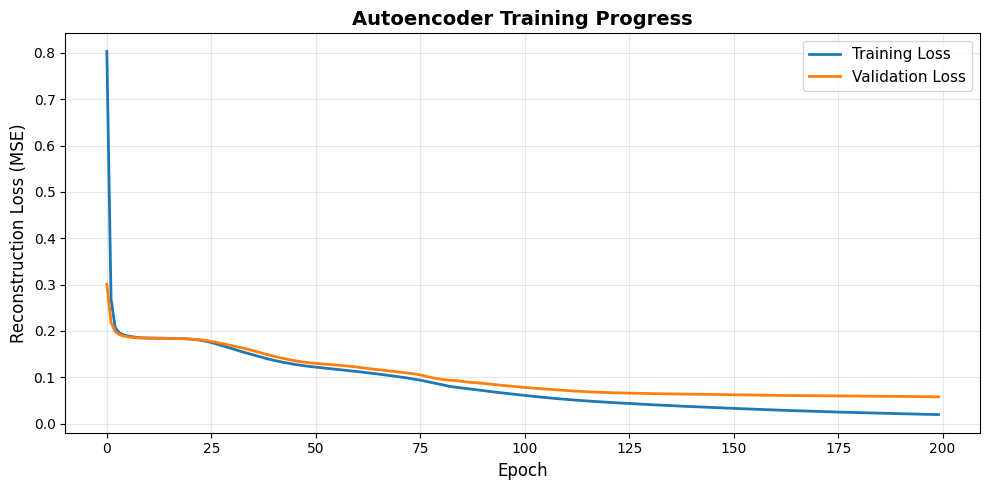


✅ Training complete!
   Final training loss: 0.019643
   Final validation loss: 0.057995


In [111]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 4: Training the Autoencoder 🎯

# In this exercise, you will:
# 1. Implement a complete training loop for the autoencoder
# 2. Monitor training and validation losses
# 3. Track reconstruction quality over epochs

def train_autoencoder(model, 
                     train_data, 
                     val_data, 
                     optimizer, 
                     criterion,
                     epochs=200):
    """
    Train an autoencoder model
    
    Args:
        model: PyTorch autoencoder model
        train_data: Training features (input = target for autoencoders!)
        val_data: Validation features
        optimizer: PyTorch optimizer
        criterion: Loss function
        epochs: Number of training epochs
        
    Returns:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
    """
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training Autoencoder"):
        # === TRAINING PHASE ===
        model.train()
        
         # 1. Zero gradients
        optimizer.zero_grad()
        
        # 2. Forward pass: Reconstruct the input
        reconstructed = model(train_data)
        
        # 3. Compute reconstruction loss (compare input with reconstruction)
        train_loss = criterion(reconstructed, train_data)  # Target = input!
        
        # 4. Backward pass
        train_loss.backward()
        
        # 5. Update weights
        optimizer.step()
        
        # Store training loss
        train_losses.append(train_loss.item())
        
        # === VALIDATION PHASE ===
        model.eval()
        with torch.no_grad():
            val_reconstructed = model(val_data)
            val_loss = criterion(val_reconstructed, val_data)
            val_losses.append(val_loss.item())
    
    return train_losses, val_losses

# Train the model
print("🏋️ Training autoencoder on normal heart sounds...")
train_losses, val_losses = train_autoencoder(
    model=model,
    train_data=X_train_tensor,
    val_data=X_val_tensor,
    optimizer=optimizer,
    criterion=loss_function,
    epochs=200
)

# Plot training progress
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Training Loss', linewidth=2)
ax.plot(val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Reconstruction Loss (MSE)', fontsize=12)
ax.set_title('Autoencoder Training Progress', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Training complete!")
print(f"   Final training loss: {train_losses[-1]:.6f}")
print(f"   Final validation loss: {val_losses[-1]:.6f}")



### Overfitting, Underfitting, and Early Stopping
***
> <img src="../figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Overfitting occurs when a model learns the training data too well, including noise and outliers, leading to poor generalisation on unseen data. Underfitting occurs when a model is too simple to capture the underlying patterns in the data.

As we can see in the following figure, the training loss decreases over time, while the validation loss follows a similar trend. However, the validation loss starts to slowly deviate from the training loss after a certain number of epochs. This indicates that the model is starting to overfit the training data. The point at which the validation loss starts to increase is known as the "early stopping" point. This is the point at which we should stop training the model to prevent overfitting.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="../figs\over_under_fit.png" alt="Overfitting" align="center" style="width: 60%; height: auto; margin: 0 auto;">

## Step 10: Evaluate Model - Anomaly Detection
***

### Using Reconstruction Error for Anomaly Detection

The core principle: **Models trained on normal data struggle to reconstruct abnormal patterns.**

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/docs.svg" width="20"/> **Anomaly Score**: The reconstruction error serves as an anomaly score. Higher error = more abnormal.

$$\text{Anomaly Score} = ||\mathbf{x} - \mathbf{\hat{x}}||^2 = \sum_{i=1}^{n}(x_i - \hat{x}_i)^2$$

### Evaluation Strategy

1. **Compute reconstruction errors** for all test samples
2. **Set a threshold** to distinguish normal from abnormal
3. **Calculate metrics**: Accuracy, precision, recall, F1-score
4. **Visualize** the distribution of errors for normal vs. abnormal sounds

### Choosing the Threshold

| Method | Description | When to Use |
|--------|-------------|-------------|
| **Statistical** | Mean + k×std of normal training errors | When normal data is clean |
| **Percentile** | 95th or 99th percentile of training errors | Robust to outliers |
| **ROC-based** | Threshold that maximizes TPR - FPR | When you have validation labels |
| **Domain-specific** | Clinical guidelines | When expert knowledge exists |

### Performance Metrics

For anomaly detection:

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **True Positive Rate (Recall)** | $\frac{TP}{TP + FN}$ | % of abnormals correctly identified |
| **False Positive Rate** | $\frac{FP}{FP + TN}$ | % of normals incorrectly flagged |
| **Precision** | $\frac{TP}{TP + FP}$ | % of alerts that are true abnormals |
| **F1 Score** | $2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$ | Harmonic mean of precision and recall |

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 3**: Evaluate Autoencoder for Anomaly Detection

```python
# Set model to evaluation mode
model.eval()

# Compute reconstruction errors
with torch.no_grad():
    reconstructed = model(test_data)
    reconstruction_errors = torch.mean((test_data - reconstructed)**2, dim=1)

# Set threshold (e.g., 95th percentile of training errors)
threshold = torch.quantile(train_errors, 0.95)

# Classify as anomaly if error > threshold
predictions = (reconstruction_errors > threshold).float()
```

### Clinical Significance

In medical applications, we must balance:
- **High Recall**: Don't miss serious conditions (minimize false negatives)
- **Acceptable Precision**: Avoid alarm fatigue (minimize false positives)

The threshold choice depends on clinical priorities and downstream workflow.

In [112]:
# <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Exercise 5: Evaluate the Autoencoder for Anomaly Detection 🎯

# In this exercise, you will:
# 1. Compute reconstruction errors for all test samples
# 2. Set a threshold to distinguish normal from abnormal
# 3. Calculate performance metrics

print("=" * 70)
print("EVALUATING AUTOENCODER FOR ANOMALY DETECTION")
print("=" * 70)

model.eval()

with torch.no_grad():
    # Compute reconstruction errors for training data (to set threshold)
    train_reconstructed = model(X_train_tensor)
    train_errors = torch.mean((X_train_tensor - train_reconstructed)**2, dim=1)
    
    # Compute reconstruction errors for test data
    test_reconstructed = model(X_test_tensor)
    test_errors = torch.mean((X_test_tensor - test_reconstructed)**2, dim=1)

# Set threshold as 95th percentile of training errors
threshold = torch.quantile(train_errors, 0.95).item()

print(f"\n📊 Reconstruction Error Statistics:")
print(f"   Training (normal) - Mean: {train_errors.mean().item():.6f}, Std: {train_errors.std().item():.6f}")
print(f"   Test set - Mean: {test_errors.mean().item():.6f}, Std: {test_errors.std().item():.6f}")
print(f"   Threshold (95th percentile): {threshold:.6f}")

# Classify test samples as anomaly if error > threshold
predictions = (test_errors > threshold).float()

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test_tensor.numpy(), predictions.numpy())
precision = precision_score(y_test_tensor.numpy(), predictions.numpy(), zero_division=0)
recall = recall_score(y_test_tensor.numpy(), predictions.numpy())
f1 = f1_score(y_test_tensor.numpy(), predictions.numpy())

print(f"\n🎯 Anomaly Detection Performance:")
print(f"   Accuracy:  {accuracy:.3f}")
print(f"   Precision: {precision:.3f} (of flagged anomalies, how many are true?)")
print(f"   Recall:    {recall:.3f} (of true anomalies, how many did we catch?)")
print(f"   F1 Score:  {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test_tensor.numpy(), predictions.numpy())
print(f"\n📋 Confusion Matrix:")
print(f"               Predicted")
print(f"             Normal  Abnormal")
print(f"Actual Normal    {cm[0,0]:3d}     {cm[0,1]:3d}")
print(f"      Abnormal   {cm[1,0]:3d}     {cm[1,1]:3d}")

print(f"\n✅ Evaluation complete!")

EVALUATING AUTOENCODER FOR ANOMALY DETECTION

📊 Reconstruction Error Statistics:
   Training (normal) - Mean: 0.019446, Std: 0.014930
   Test set - Mean: 0.299403, Std: 0.189443
   Threshold (95th percentile): 0.047772

🎯 Anomaly Detection Performance:
   Accuracy:  0.896
   Precision: 0.887 (of flagged anomalies, how many are true?)
   Recall:    1.000 (of true anomalies, how many did we catch?)
   F1 Score:  0.940

📋 Confusion Matrix:
               Predicted
             Normal  Abnormal
Actual Normal     34      47
      Abnormal     0     369

✅ Evaluation complete!


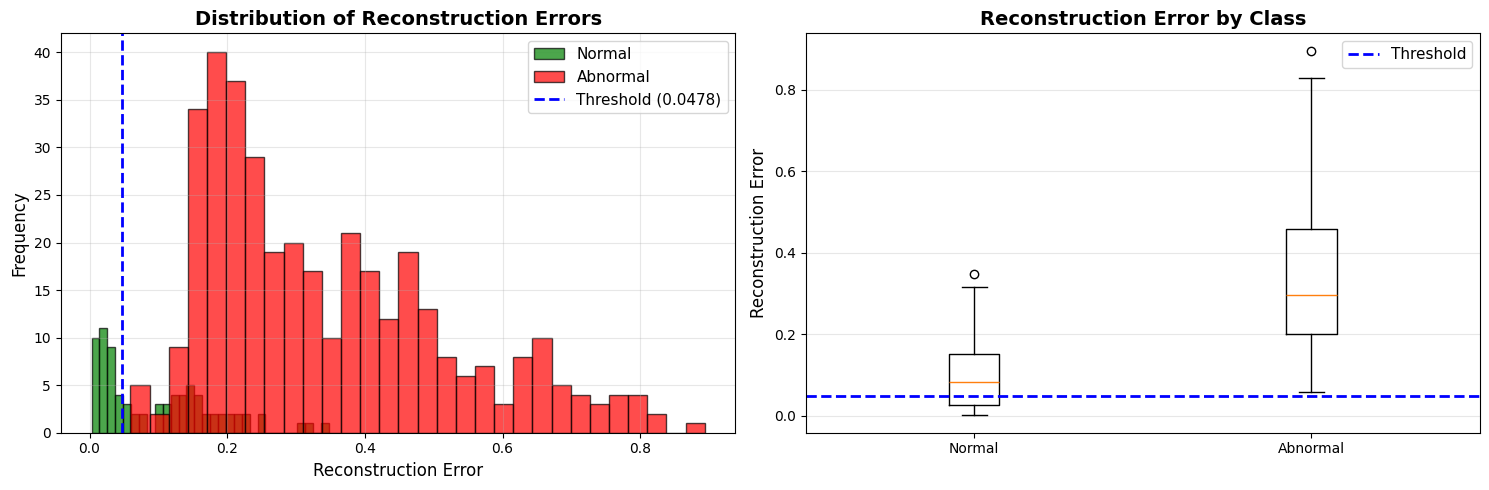


📊 Key findings:
   • Normal sounds: Mean reconstruction error = 0.1001
   • Abnormal sounds: Mean reconstruction error = 0.3432
   • Separation: 3.4x higher for abnormal

✅ The autoencoder successfully learned to distinguish normal from abnormal heart sounds!


In [113]:
# Visualize reconstruction error distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Separate errors by class
test_normal_errors = test_errors[y_test_tensor == 0].numpy()
test_abnormal_errors = test_errors[y_test_tensor == 1].numpy()

# Histogram of errors
axes[0].hist(test_normal_errors, bins=30, alpha=0.7, label='Normal', color='green', edgecolor='black')
axes[0].hist(test_abnormal_errors, bins=30, alpha=0.7, label='Abnormal', color='red', edgecolor='black')
axes[0].axvline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')
axes[0].set_xlabel('Reconstruction Error', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Reconstruction Errors', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([test_normal_errors, test_abnormal_errors], tick_labels=['Normal', 'Abnormal'])
axes[1].axhline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold')
axes[1].set_ylabel('Reconstruction Error', fontsize=12)
axes[1].set_title('Reconstruction Error by Class', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Key findings:")
print(f"   • Normal sounds: Mean reconstruction error = {test_normal_errors.mean():.4f}")
print(f"   • Abnormal sounds: Mean reconstruction error = {test_abnormal_errors.mean():.4f}")
print(f"   • Separation: {(test_abnormal_errors.mean() / test_normal_errors.mean()):.1f}x higher for abnormal")
print(f"\n✅ The autoencoder successfully learned to distinguish normal from abnormal heart sounds!")